In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r'data/processed/preprocessed_data.csv')
df.head()

,Maker,Gearbox,Fuel_type,Price,Engine_size,Prod_year,Model,Body_type,Runned_km
0,bentley,automatic,petrol,104060.0,6.8,2000.0,arnage,saloon,96560.0
1,bentley,automatic,petrol,139150.0,6.8,2002.0,arnage,saloon,70811.0
2,bentley,automatic,petrol,145195.0,6.8,2002.0,arnage,saloon,88514.0
3,bentley,automatic,petrol,169148.0,6.8,2003.0,arnage,saloon,22531.0
4,bentley,automatic,petrol,128526.0,6.8,2003.0,arnage,saloon,99219.0


In [3]:
df.duplicated().sum()

np.int64(913)

In [4]:
target = 'Price'

num_features = df.select_dtypes(include=['number']).columns.drop(target)
cat_features = df.select_dtypes(include=['object', 'category']).columns

X = df[num_features.tolist() + cat_features.tolist()]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# LR pipeline
lr_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_features)
    ]
)

lr_pipeline = Pipeline([
    ('preprocessor', lr_preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluation 
r2_lr = r2_score(y_test, y_pred_lr)
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print("=== Linear Regression ===")
print(f"Test MAE: {mae_lr:.2f}")
print(f"Test R^2: {r2_lr:.4f}")
print(f"Test MAPE: {mape_lr:.2f}")

=== Linear Regression ===
Test MAE: 14499.65
Test R^2: 0.8554
Test MAPE: 0.60


In [5]:
features_num = df.select_dtypes(include=['number']).columns.drop('Price').to_list()
features_cat = df.select_dtypes(include=['object']).columns.to_list()
features = features_num + features_cat
X = df[features].copy()
y = df["Price"]

encoders = {}  
for feature in features_cat:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])
    encoders[feature] = le

X_train_rf, X_test_rf, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,        
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train_rf, y_train)
y_pred_rf = rf_model.predict(X_test_rf)

# Evaluation 
r2_rf = r2_score(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("=== Random Forest ===")
print(f"Test MAE: {mae_rf:.2f}")
print(f"Test R^2: {r2_rf:.4f}")
print(f"Test MAPE: {mape_rf:.2f}")

=== Random Forest ===
Test MAE: 6161.90
Test R^2: 0.9637
Test MAPE: 0.14


Feature importances:
Engine_size    0.397002
Prod_year      0.238447
Runned_km      0.217340
Model          0.060457
Maker          0.044386
Body_type      0.025015
Gearbox        0.011901
Fuel_type      0.005452
dtype: float64


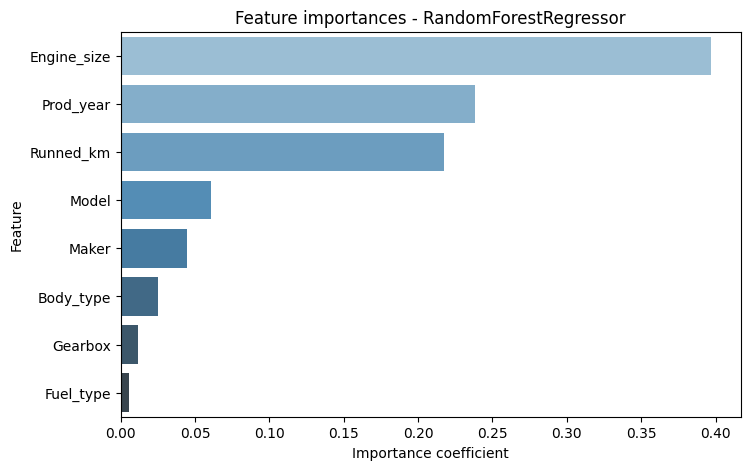

In [6]:
feat_imp = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)
print("Feature importances:")
print(feat_imp)

plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="Blues_d")
plt.title("Feature importances - RandomForestRegressor")
plt.xlabel("Importance coefficient")
plt.ylabel("Feature")
plt.show()

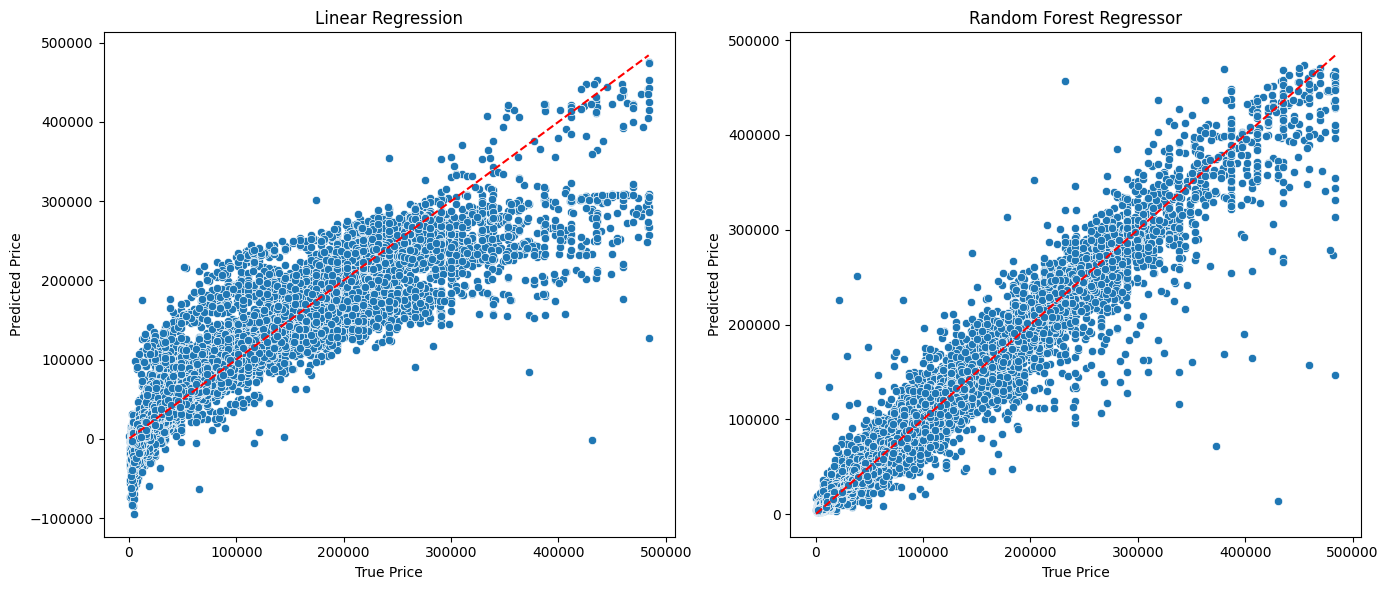

In [7]:
plt.figure(figsize=(14, 6))

# LR subplot
plt.subplot(1, 2, 1)  
sns.scatterplot(x=y_test, y=y_pred_lr)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--')
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("Linear Regression")

# RF subplot
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--')
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("Random Forest Regressor")

plt.tight_layout()
plt.show()

In [8]:
with open("encoders.pkl", "wb") as f:
    pickle.dump(encoders, f)

In [9]:
with open("rf_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)